In [1]:
from utils import *

# KNN classification

In [7]:
df, train, test, val = get_data(normalize=False, binary_label=True)  # best normalized

In [3]:

from scipy.spatial.distance import cdist


class ScratchKNeighbors:
    def __init__(self, classification, n_neighbors=5):
        self.n_neighbors = n_neighbors
        self.X_train = None
        self.y_train = None
        self.classification = classification

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        distances = cdist(X_test, self.X_train)
        nearest_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]
        nearest_targets = self.y_train[nearest_indices]
        predictions = np.mean(nearest_targets, axis=1)
        if self.classification:  #Majority vote is useless
            return predictions >= 0.5
        return predictions

## Sklearn

In [8]:
from sklearn.neighbors import KNeighborsClassifier

regressor = KNeighborsClassifier(n_neighbors=5)

test_model(regressor, train, test, classification=True)

Time taken to train the model:  0.0025610923767089844
Binary cross entropy: 15.382989414651588
Accuracy: 0.5732122587968218


0.5732122587968218

Trying hyperparameters: 1
Time taken to train the model:  0.003071308135986328
Binary cross entropy: 16.22333760459238
Accuracy: 0.5498975248305218
Value: 0.5498975248305218
Trying hyperparameters: 6
Time taken to train the model:  0.0017962455749511719
Binary cross entropy: 15.75169591591246
Accuracy: 0.5629828157023491
Value: 0.5629828157023491
Trying hyperparameters: 11
Time taken to train the model:  0.0026748180389404297
Binary cross entropy: 15.353925817025784
Accuracy: 0.574018603184613
Value: 0.574018603184613
Trying hyperparameters: 16
Time taken to train the model:  0.0017845630645751953
Binary cross entropy: 15.348243387041688
Accuracy: 0.5741762572915025
Value: 0.5741762572915025
Trying hyperparameters: 21
Time taken to train the model:  0.0017838478088378906
Binary cross entropy: 15.155040767582445
Accuracy: 0.5795364969257449
Value: 0.5795364969257449
Trying hyperparameters: 26
Time taken to train the model:  0.0017366409301757812
Binary cross entropy: 15.149358337598349


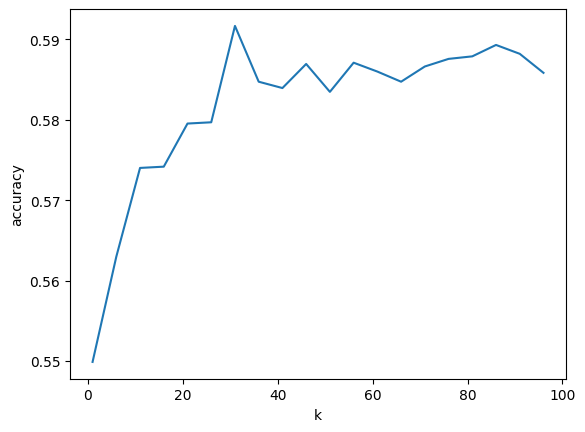

Time taken to train the model:  0.002134561538696289
Binary cross entropy: 14.751123123683334
Accuracy: 0.5907428427292218


0.5907428427292218

In [9]:
def get_model(param):
    return KNeighborsClassifier(n_neighbors=param)


best_param, params, accuracies = optimize_hyperparameters(get_model, range(1, 100, 5), train, test, val,
                                                          classification=True)
plot_2d(params, accuracies, 'k', 'accuracy')
best_model = get_model(best_param)

accuracy_KNN_sk = test_model(best_model, train, test, classification=True)

In [10]:
regressor = ScratchKNeighbors(classification=True, n_neighbors=5)
accuracy_KNN_my = test_model(regressor, train, test, classification=True)

Time taken to train the model:  3.337860107421875e-06
Binary cross entropy: 15.382989414651588
Accuracy: 0.5732122587968218


0.5732122587968218

# KNN regression

In [18]:
df, train, test, val = get_data(normalize=False, binary_label=False)


## Sklearn

In [19]:
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=5)

test_model(regressor, train, test, classification=False)

Time taken to train the model:  0.0016429424285888672
Root Mean Squared Error: 9314.63167163207


9314.63167163207

Trying hyperparameters: 1
Time taken to train the model:  0.0016160011291503906
Root Mean Squared Error: 15225.924163065538
Value: 15225.924163065538
Trying hyperparameters: 6
Time taken to train the model:  0.001226663589477539
Root Mean Squared Error: 8490.828485311627
Value: 8490.828485311627
Trying hyperparameters: 11
Time taken to train the model:  0.0011429786682128906
Root Mean Squared Error: 8055.688675956313
Value: 8055.688675956313
Trying hyperparameters: 16
Time taken to train the model:  0.0012941360473632812
Root Mean Squared Error: 7846.124723319356
Value: 7846.124723319356
Trying hyperparameters: 21
Time taken to train the model:  0.0011665821075439453
Root Mean Squared Error: 7810.077348671558
Value: 7810.077348671558
Trying hyperparameters: 26
Time taken to train the model:  0.0012354850769042969
Root Mean Squared Error: 7724.9434767499315
Value: 7724.9434767499315
Trying hyperparameters: 31
Time taken to train the model:  0.001165628433227539
Root Mean Squared Error: 

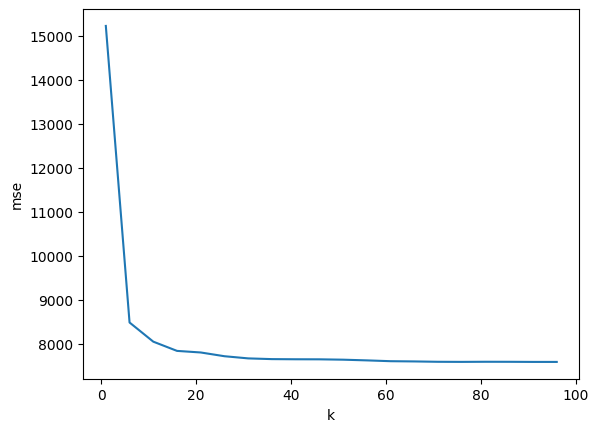

Time taken to train the model:  0.001542806625366211
Root Mean Squared Error: 9314.63167163207


In [20]:
def get_model(param):
    return KNeighborsRegressor(n_neighbors=param)


best_param, params, accuracies = optimize_hyperparameters(get_model, range(1, 100, 5), train, test, val,
                                                          classification=False)
plot_2d(params, accuracies, 'k', 'mse')
best_model = get_model(best_param)

rmse_KNN_sk = test_model(regressor, train, test, classification=False)

In [21]:
regressor = ScratchKNeighbors(classification=False, n_neighbors=5)
rmse_KNN_my = test_model(regressor, train, test, classification=False)


Time taken to train the model:  2.1457672119140625e-06
Root Mean Squared Error: 9314.63167163207


9314.63167163207

In [30]:
class ScratchLocallyWeightedLinearRegression:
    def __init__(self, num_iter, lr, kernel_func, kernel_func_params):
        self.num_iter = num_iter
        self.lr = lr
        self.kernel_func = kernel_func
        self.kernel_func_params = kernel_func_params
        self.w = None

    def fit(self, X, y):
        self.w = np.random.rand(X.shape[1])
        for i in range(self.num_iter):
            for j in range(X.shape[0]):
                x = X[j]
                y_pred = self.predict(x)
                error = y[j] - y_pred
                k = self.kernel_func(x, X, self.kernel_func_params)

                # self.w += self.lr * error * k
                # self.w+=self.lr *error * np.dot(k,x)

                self.w += self.lr * np.dot(error, k)

    def predict(self, X):
        return np.dot(X, self.w)


def gaussian_kernel(x, X, params):
    sigma = params['sigma']
    distances = np.linalg.norm(x - X, axis=1)
    return np.exp(-distances ** 2 / (2 * sigma ** 2))


regressor = ScratchLocallyWeightedLinearRegression(num_iter=100, lr=0.01, kernel_func=gaussian_kernel,
                                                   kernel_func_params={'sigma': 1})

test_model(regressor, train_x, train_y, test_x, test_y)

ValueError: operands could not be broadcast together with shapes (58,) (31715,) (58,) 